# Explore CWatM data

In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import sys
sys.path.append("..")

from pathlib import Path
from functools import reduce
from tqdm.notebook import tqdm

import pandas as pd
import xarray as xr

import plotly.express as px

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
RAW_DATA_FOLDER_PATH = Path("../data/raw/CWatM_ISIMIP3_4Thorsten")


## Check for missing data

In [4]:
missing_percentage_dict = {}

for file in tqdm(sorted(Path(RAW_DATA_FOLDER_PATH).rglob("*.nc")),
                 desc=f"Loading files"):
    
    temp_data = xr.load_dataset(file,
                                decode_times=False)
    temp_data = temp_data.to_dataframe()

    # check for missing values
    temp_data_missing = temp_data.isna().sum() / len(temp_data)

    missing_percentage_dict[file.name] = temp_data_missing.values


missing_percentage_df = pd.DataFrame().from_dict(missing_percentage_dict, orient="index").T

Loading files:   0%|          | 0/73 [00:00<?, ?it/s]

In [5]:
missing_percentage_df

,landsea_converted.nc,kSatAquifer.nc,porosity_GLHYMPS1.nc,recessionCoeff.nc,cropCoefficientForest_10days.nc,interceptCapForest_10days.nc,maxRootDepth.nc,minSoilDepthFrac.nc,rootFraction1.nc,rootFraction2.nc,...,lambda3_30min.nc,percolationImp.nc,storageDepth1.nc,storageDepth2.nc,thetar1_30min.nc,thetar2_30min.nc,thetar3_30min.nc,thetas1_30min.nc,thetas2_30min.nc,thetas3_30min.nc
0,0.000000,0.740517,0.0,0.740517,0.740517,0.740517,0.0,0.740417,0.740517,0.740517,...,0.0,0.740517,0.740517,0.740517,0.0,0.0,0.0,0.0,0.0,0.0
1,0.739892,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
fig = px.strip(missing_percentage_df,
               orientation="h",
               width=600,
               height=1000)

fig.update_xaxes(showgrid=True)
fig.update_yaxes(showgrid=True)

## 2. Account for land coverage

In the file `landsea_converted.nc`, the column `Band1` indicates if that location is land. Let's recompute the % of missing data over land.

In [7]:
landsea_converted = xr.load_dataset(RAW_DATA_FOLDER_PATH.joinpath("areamaps", "landsea_converted.nc"))

In [8]:
landsea_converted

<xarray.Dataset> Size: 1MB
Dimensions:  (lat: 360, lon: 720)
Coordinates:
  * lat      (lat) float64 3kB -89.75 -89.25 -88.75 -88.25 ... 88.75 89.25 89.75
  * lon      (lon) float64 6kB -179.8 -179.2 -178.8 -178.2 ... 178.8 179.2 179.8
Data variables:
    crs      |S1 1B b''
    Band1    (lat, lon) float32 1MB nan nan nan nan nan ... nan nan nan nan nan
Attributes:
    GDAL_AREA_OR_POINT:  Area
    Conventions:         CF-1.5
    GDAL:                GDAL 3.1.2, released 2020/07/07
    history:             Tue Oct 19 09:36:45 2021: GDAL CreateCopy( landsea_c...

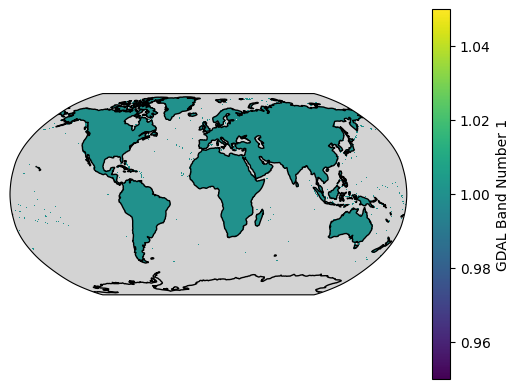

In [9]:
import cartopy.crs as ccrs


p = landsea_converted.Band1.plot(
    subplot_kws=dict(projection=ccrs.Robinson(), facecolor="lightgray"),
    transform=ccrs.PlateCarree(),
)

p.axes.set_global()

p.axes.coastlines()

In [10]:
landsea_converted_df = landsea_converted.to_dataframe().reset_index()[["lat", "lon", "Band1"]]
landsea_converted_df = landsea_converted_df[~landsea_converted_df["Band1"].isna()]

In [11]:
fig = px.scatter_geo(landsea_converted_df,
                     lat="lat", lon="lon",
                     projection="natural earth")
fig.show()

In [12]:
missing_percentage_dict = {}

for file in tqdm(sorted(Path(RAW_DATA_FOLDER_PATH).rglob("*.nc")),
                 desc=f"Loading files"):
    
    if file.name == "landsea_converted.nc":
        continue
    
    temp_data = xr.load_dataset(file,
                                decode_times=False)
    temp_data = temp_data.to_dataframe()

    temp_data = temp_data.reset_index()
    temp_data_cols = temp_data.columns.copy()
    temp_data = pd.merge(left=landsea_converted_df, right=temp_data,
                         how="left",
                         on=["lat", "lon"])
    temp_data = temp_data[[col for col in temp_data_cols if col not in ["lat", "lon"]]]

    # check for missing values
    temp_data_missing = temp_data.isna().sum() / len(temp_data)

    missing_percentage_dict[file.name] = temp_data_missing.values


missing_percentage_df = pd.DataFrame().from_dict(missing_percentage_dict, orient="index").T

Loading files:   0%|          | 0/73 [00:00<?, ?it/s]

In [13]:
missing_percentage_df

,kSatAquifer.nc,porosity_GLHYMPS1.nc,recessionCoeff.nc,cropCoefficientForest_10days.nc,interceptCapForest_10days.nc,maxRootDepth.nc,minSoilDepthFrac.nc,rootFraction1.nc,rootFraction2.nc,cropCoefficientGrassland_10days.nc,...,lambda3_30min.nc,percolationImp.nc,storageDepth1.nc,storageDepth2.nc,thetar1_30min.nc,thetar2_30min.nc,thetar3_30min.nc,thetas1_30min.nc,thetas2_30min.nc,thetas3_30min.nc
0,0.016197,0.0,0.016197,0.000000,0.000000,0.0,0.015811,0.016197,0.016197,0.000000,...,0.0,0.016197,0.016197,0.016197,0.0,0.0,0.0,0.0,0.0,0.0
1,NaN,NaN,NaN,0.016197,0.016197,NaN,NaN,NaN,NaN,0.016197,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [14]:
fig = px.strip(missing_percentage_df,
               orientation="h",
               width=600,
               height=1000)

fig.update_xaxes(showgrid=True)
fig.update_yaxes(showgrid=True)